In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import string
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/BhavanishDhamnaskar/finNews-/main/all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
# Number of rows and columns
data.shape

(4846, 2)

In [5]:
# Get the summary statistics of the data
print(data.describe())

       sentiment                                               text
count       4846                                               4846
unique         3                                               4838
top      neutral  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq        2879                                                  2


In [6]:
# Check for missing values
print(data.isnull().sum())

sentiment    0
text         0
dtype: int64


In [7]:
# Balance of classes
classes_distribution = data['sentiment'].value_counts(normalize=True)
classes_distribution

sentiment
neutral     0.594098
positive    0.281263
negative    0.124639
Name: proportion, dtype: float64

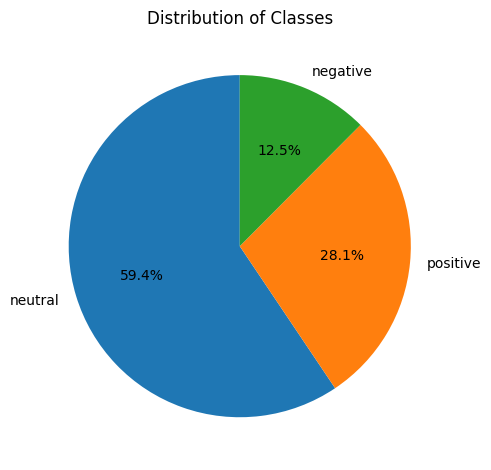

In [8]:
labels = classes_distribution.index
values = classes_distribution.values
plt.pie(values, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.tight_layout()
plt.show()

In [9]:
# Headlines length
data['n_words'] = data['text'].str.split()  # Split sentences by spaces and convert into lists of words
data['n_words'] = data['n_words'].apply(lambda x: [word for word in x if len(word) > 1])  # Remove words shorter than 2 characters
data['n_words'] = data['n_words'].apply(lambda x: len(x))

In [10]:
# Length statistics
min_length = data['n_words'].min()
max_length = data['n_words'].max()
mean_length = data['n_words'].mean()
median_length = data['n_words'].median()

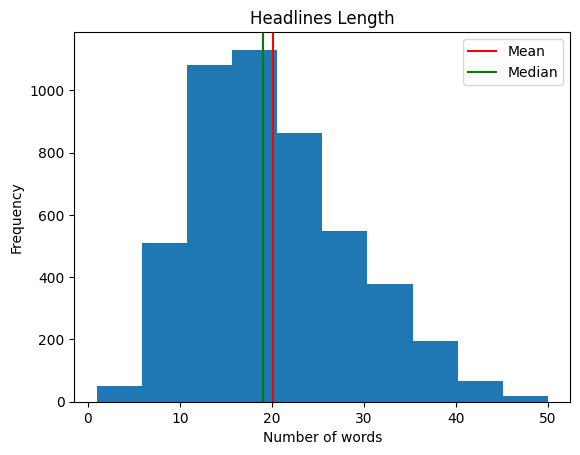

In [11]:
plt.hist(data['n_words'], bins=10)
plt.axvline(mean_length, color='red', label='Mean')
plt.axvline(median_length, color='green', label='Median')
plt.legend()
plt.title('Headlines Length')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [12]:
print(f'Sentence length: {min_length} - {max_length} words\nMean length = {mean_length}\nMedian length = {median_length}')

Sentence length: 1 - 50 words
Mean length = 20.103796945934793
Median length = 19.0


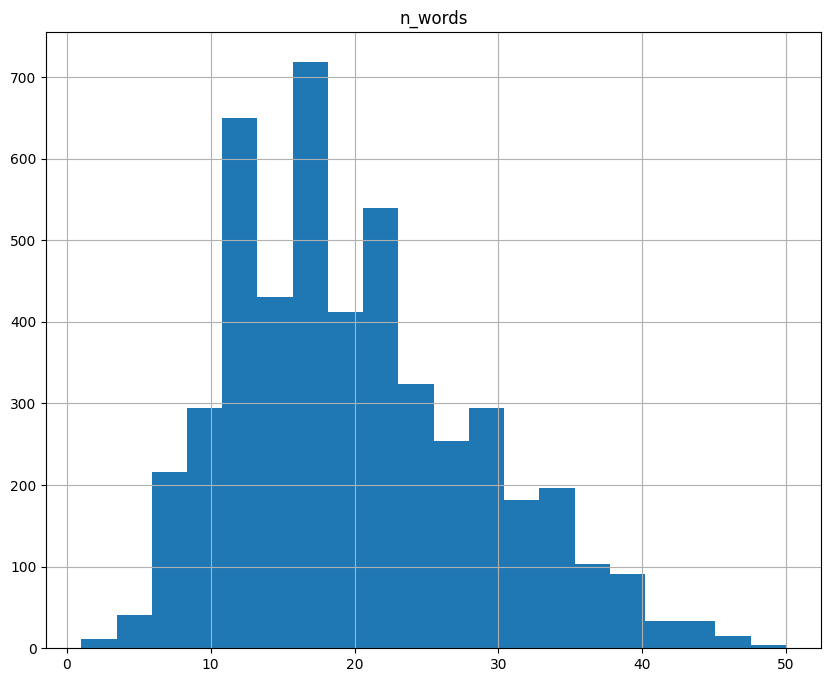

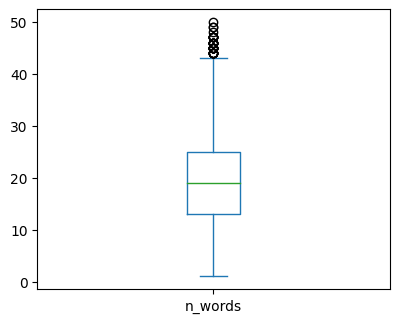

In [13]:
# Histogram for numerical features
data.hist(figsize=(10, 8), bins=20)
plt.show()

# Boxplot for numerical features to identify outliers
data.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(10, 8))
plt.show()

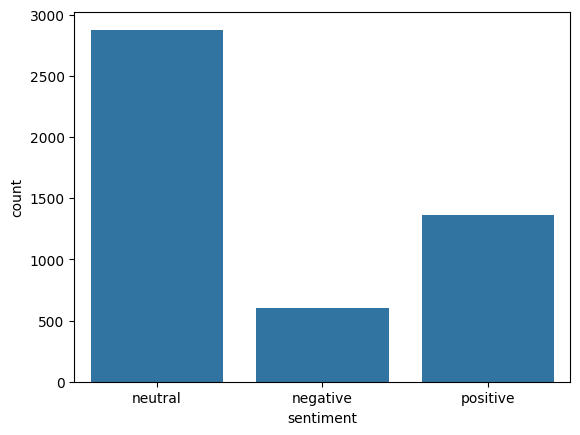

In [14]:
# Assuming 'species' is a categorical column in the dataset
sns.countplot(x='sentiment', data=data)
plt.show()

In [15]:
# Ensure that you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<ipython-input-16-77e68d689eb2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='viridis')


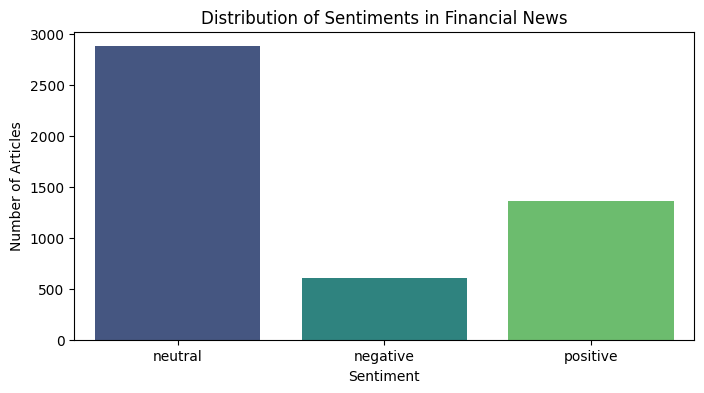

In [16]:
# Visualize the distribution of sentiments with a bar plot
plt.figure(figsize=(8, 4))
sns.countplot(x='sentiment', data=data, palette='viridis')
plt.title('Distribution of Sentiments in Financial News')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

## TEXT PRE-PROCESSING

**REMOVING PUNCTUATIONS**

In [17]:
#remove punctuations
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['text'] = data['text'].apply(lambda x: remove_punct(x))
data.head(10)

,sentiment,text,n_words
0,neutral,According to Gran the company has no plans to...,22
1,neutral,Technopolis plans to develop in stages an area...,29
2,negative,The international electronic industry company ...,33
3,positive,With the new production plant the company woul...,32
4,positive,According to the company s updated strategy fo...,34
5,positive,FINANCING OF ASPOCOMP S GROWTH Aspocomp is agg...,24
6,positive,For the last quarter of Componenta s net sal...,33
7,positive,In the third quarter of net sales increased ...,24
8,positive,Operating profit rose to EUR mn from EUR mn ...,22
9,positive,Operating profit totalled EUR mn up from EUR...,18


In [18]:
#stopwords removal
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["text_wo_stop"] = data["text"].apply(lambda text: remove_stopwords(text))
data.head()


,sentiment,text,n_words,text_wo_stop
0,neutral,According to Gran the company has no plans to...,22,According Gran company plans move production R...
1,neutral,Technopolis plans to develop in stages an area...,29,Technopolis plans develop stages area less squ...
2,negative,The international electronic industry company ...,33,The international electronic industry company ...
3,positive,With the new production plant the company woul...,32,With new production plant company would increa...
4,positive,According to the company s updated strategy fo...,34,According company updated strategy years Baswa...


In [20]:
#remove
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

data.head(20)

,sentiment,text,n_words,text_wo_stop
0,neutral,According to Gran the company has no plans to move all production to Russia although that is w...,22,According Gran company plans move production Russia although company growing
1,neutral,Technopolis plans to develop in stages an area of no less than square meters in order to host c...,29,Technopolis plans develop stages area less square meters order host companies working computer t...
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,33,The international electronic industry company Elcoteq laid tens employees Tallinn facility contr...
3,positive,With the new production plant the company would increase its capacity to meet the expected incre...,32,With new production plant company would increase capacity meet expected increase demand would im...
4,positive,According to the company s updated strategy for the years Basware targets a longterm net sales...,34,According company updated strategy years Basware targets longterm net sales growth range operati...
5,positive,FINANCING OF ASPOCOMP S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasi...,24,FINANCING OF ASPOCOMP S GROWTH Aspocomp aggressively pursuing growth strategy increasingly focus...
6,positive,For the last quarter of Componenta s net sales doubled to EURm from EURm for the same period a...,33,For last quarter Componenta net sales doubled EURm EURm period year earlier moved zero pretax pr...
7,positive,In the third quarter of net sales increased by to EUR mn and operating profit by to EUR ...,24,In third quarter net sales increased EUR mn operating profit EUR mn
8,positive,Operating profit rose to EUR mn from EUR mn in the corresponding period in representing of ...,22,Operating profit rose EUR mn EUR mn corresponding period representing net sales
9,positive,Operating profit totalled EUR mn up from EUR mn in representing of net sales,18,Operating profit totalled EUR mn EUR mn representing net sales


# STEMMING AND LEMMATIZATION OF TEXT DATA

In [21]:
#stemming and lemmatization
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
data["text_stemmed"] = data["text_wo_stop"].apply(lambda text: stem_words(text))
data.head()

,sentiment,text,n_words,text_wo_stop,text_stemmed
0,neutral,According to Gran the company has no plans to move all production to Russia although that is w...,22,According Gran company plans move production Russia although company growing,accord gran compani plan move product russia although compani grow
1,neutral,Technopolis plans to develop in stages an area of no less than square meters in order to host c...,29,Technopolis plans develop stages area less square meters order host companies working computer t...,technopoli plan develop stage area less squar meter order host compani work comput technolog tel...
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,33,The international electronic industry company Elcoteq laid tens employees Tallinn facility contr...,the intern electron industri compani elcoteq laid ten employe tallinn facil contrari earlier lay...
3,positive,With the new production plant the company would increase its capacity to meet the expected incre...,32,With new production plant company would increase capacity meet expected increase demand would im...,with new product plant compani would increas capac meet expect increas demand would improv use r...
4,positive,According to the company s updated strategy for the years Basware targets a longterm net sales...,34,According company updated strategy years Basware targets longterm net sales growth range operati...,accord compani updat strategi year baswar target longterm net sale growth rang oper profit margi...


# COUNT VECTORIZATION

In [22]:
#remove frequent words - countvectorization
from collections import Counter
cnt = Counter()
for text in data["text_stemmed"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(20)

[('the', 1354),
 ('eur', 1310),
 ('compani', 971),
 ('mn', 593),
 ('oper', 571),
 ('said', 544),
 ('finnish', 513),
 ('sale', 501),
 ('million', 442),
 ('share', 438),
 ('profit', 430),
 ('net', 413),
 ('servic', 341),
 ('finland', 337),
 ('year', 331),
 ('group', 328),
 ('product', 324),
 ('new', 317),
 ('market', 317),
 ('mln', 290)]

**REMOVAL OF THE MOST FREQUENT WORDS**

In [23]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data["text__stopfreq"] = data["text_stemmed"].apply(lambda text: remove_freqwords(text))
data.head()

,sentiment,text,n_words,text_wo_stop,text_stemmed,text__stopfreq
0,neutral,According to Gran the company has no plans to move all production to Russia although that is w...,22,According Gran company plans move production Russia although company growing,accord gran compani plan move product russia although compani grow,accord gran plan move product russia although grow
1,neutral,Technopolis plans to develop in stages an area of no less than square meters in order to host c...,29,Technopolis plans develop stages area less square meters order host companies working computer t...,technopoli plan develop stage area less squar meter order host compani work comput technolog tel...,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,33,The international electronic industry company Elcoteq laid tens employees Tallinn facility contr...,the intern electron industri compani elcoteq laid ten employe tallinn facil contrari earlier lay...,intern electron industri elcoteq laid ten employe tallinn facil contrari earlier layoff contract...
3,positive,With the new production plant the company would increase its capacity to meet the expected incre...,32,With new production plant company would increase capacity meet expected increase demand would im...,with new product plant compani would increas capac meet expect increas demand would improv use r...,with new product plant would increas capac meet expect increas demand would improv use raw mater...
4,positive,According to the company s updated strategy for the years Basware targets a longterm net sales...,34,According company updated strategy years Basware targets longterm net sales growth range operati...,accord compani updat strategi year baswar target longterm net sale growth rang oper profit margi...,accord updat strategi year baswar target longterm net growth rang profit margin net


In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [26]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

data["text_lemmatized"] = data["text__stopfreq"].apply(lambda text: lemmatize_words(text))
data.head()

,sentiment,text,n_words,text_wo_stop,text_stemmed,text__stopfreq,text_lemmatized
0,neutral,According to Gran the company has no plans to move all production to Russia although that is w...,22,According Gran company plans move production Russia although company growing,accord gran compani plan move product russia although compani grow,accord gran plan move product russia although grow,accord gran plan move product russia although grow
1,neutral,Technopolis plans to develop in stages an area of no less than square meters in order to host c...,29,Technopolis plans develop stages area less square meters order host companies working computer t...,technopoli plan develop stage area less squar meter order host compani work comput technolog tel...,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,33,The international electronic industry company Elcoteq laid tens employees Tallinn facility contr...,the intern electron industri compani elcoteq laid ten employe tallinn facil contrari earlier lay...,intern electron industri elcoteq laid ten employe tallinn facil contrari earlier layoff contract...,intern electron industri elcoteq lay ten employe tallinn facil contrari earlier layoff contract ...
3,positive,With the new production plant the company would increase its capacity to meet the expected incre...,32,With new production plant company would increase capacity meet expected increase demand would im...,with new product plant compani would increas capac meet expect increas demand would improv use r...,with new product plant would increas capac meet expect increas demand would improv use raw mater...,with new product plant would increas capac meet expect increas demand would improv use raw mater...
4,positive,According to the company s updated strategy for the years Basware targets a longterm net sales...,34,According company updated strategy years Basware targets longterm net sales growth range operati...,accord compani updat strategi year baswar target longterm net sale growth rang oper profit margi...,accord updat strategi year baswar target longterm net growth rang profit margin net,accord updat strategi year baswar target longterm net growth rang profit margin net


# DROPPING THE UN-USED COLUMNS

In [27]:
#drop the columns
data=data.drop(["text_stemmed","text__stopfreq"],axis=1)

# LABEL ENCODING OF THE CATEGORICAL VARIABLES

In [28]:
#label encoding
from sklearn.preprocessing import LabelEncoder
data['encoded_category'] = LabelEncoder().fit_transform(data['sentiment'])
data[["sentiment", "encoded_category"]]


,sentiment,encoded_category
0,neutral,1
1,neutral,1
2,negative,0
3,positive,2
4,positive,2
...,...,...
4841,negative,0
4842,neutral,1
4843,negative,0
4844,negative,0


In [29]:
def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)

In [30]:
data =data.drop(["sentiment","text_wo_stop","text"],axis=1)

# PREVIEW OF THE CLEAN AND PRE-PROCESSED TEXT

In [31]:
data.head(10)

,n_words,text_lemmatized,encoded_category
0,22,accord gran plan move product russia although grow,1
1,29,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...,1
2,33,intern electron industri elcoteq lay ten employe tallinn facil contrari earlier layoff contract ...,0
3,32,with new product plant would increas capac meet expect increas demand would improv use raw mater...,2
4,34,accord updat strategi year baswar target longterm net growth rang profit margin net,2
5,24,financ of aspocomp s growth aspocomp aggress pursu growth strategi increasingli focus technolog ...,2
6,33,for last quarter componenta net doubl eurm eurm period year earlier move zero pretax profit pret...,2
7,24,in third quarter net increas profit,2
8,22,profit rise correspond period repres net,2
9,18,profit total repres net,2


# MODEL BUILDING

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

x_train,x_test,y_train,y_test = train_test_split(data.text_lemmatized,data.encoded_category,test_size = 0.3 , random_state = 0)

x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3392,), (1454,), (3392,), (1454,))

# NAIVE BAYES

In [34]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("MULTINOMIAL NAIVE BAYES")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

MULTINOMIAL NAIVE BAYES
accuracy: 69.19%
[[ 16 117  49]
 [  0 858  21]
 [  1 260 132]]
              precision    recall  f1-score   support

           0       0.94      0.09      0.16       182
           1       0.69      0.98      0.81       879
           2       0.65      0.34      0.44       393

    accuracy                           0.69      1454
   macro avg       0.76      0.47      0.47      1454
weighted avg       0.71      0.69      0.63      1454



# GRADIENT BOOSTING CLASSIFICATION MODEL

In [35]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55))])
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("GRADIENT BOOST")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GRADIENT BOOST
accuracy: 60.45%
[[  0 182   0]
 [  0 879   0]
 [  0 393   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       182
           1       0.60      1.00      0.75       879
           2       0.00      0.00      0.00       393

    accuracy                           0.60      1454
   macro avg       0.20      0.33      0.25      1454
weighted avg       0.37      0.60      0.46      1454



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBOOST CLASSIFICATION MODEL

In [36]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("XGBOOST")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:56:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


XGBOOST
accuracy: 69.39%
[[ 48 118  16]
 [ 11 833  35]
 [ 15 250 128]]
              precision    recall  f1-score   support

           0       0.65      0.26      0.38       182
           1       0.69      0.95      0.80       879
           2       0.72      0.33      0.45       393

    accuracy                           0.69      1454
   macro avg       0.69      0.51      0.54      1454
weighted avg       0.69      0.69      0.65      1454



# DECISION TREE CLASSIFICATION MODEL

In [37]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10,
                                           splitter='best',
                                           random_state=2020))])
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("DECISION TREE")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

DECISION TREE
accuracy: 70.5%
[[ 45 122  15]
 [  8 838  33]
 [  8 243 142]]
              precision    recall  f1-score   support

           0       0.74      0.25      0.37       182
           1       0.70      0.95      0.80       879
           2       0.75      0.36      0.49       393

    accuracy                           0.70      1454
   macro avg       0.73      0.52      0.55      1454
weighted avg       0.72      0.70      0.66      1454



# K- NEAREST NEIGHBOUR CLASSIFIER MODEL

In [38]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("K NEAREST NEIGHBOR")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

K NEAREST NEIGHBOR
accuracy: 70.01%
[[ 76  62  44]
 [ 22 767  90]
 [ 26 192 175]]
              precision    recall  f1-score   support

           0       0.61      0.42      0.50       182
           1       0.75      0.87      0.81       879
           2       0.57      0.45      0.50       393

    accuracy                           0.70      1454
   macro avg       0.64      0.58      0.60      1454
weighted avg       0.68      0.70      0.69      1454



CONCLUSION

Based on the above model comparison we can infer that Linear SVC model predicts the text classification at a better rate of accuracy than other models.

# CNN

In [40]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout


class Layer:
    def __init__(self, layer_type, **kwargs):
        self.layer = layer_type(**kwargs)

    def get_layer(self):
        return self.layer

class ActivationFunction:
    def __init__(self, activation):
        self.activation = activation

    def get_activation(self):
        return self.activation

class Regularization:
    def __init__(self, l1=0.0, l2=0.0):
        self.regularizer = regularizers.l1_l2(l1=l1, l2=l2)

    def get_regularizer(self):
        return self.regularizer

class DropoutLayer:
    def __init__(self, rate):
        self.dropout = Dropout(rate)

    def get_layer(self):
        return self.dropout

class CNNModel:
    def __init__(self, vocab_size, max_len, embedding_dim):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.model = Sequential()

    def add_layer(self, layer):
        self.model.add(layer.get_layer())

    def compile(self, loss, optimizer, metrics):
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def train(self, x_train, y_train, batch_size, epochs, validation_data):
        return self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def build_model(self):
        # Adding layers to the model
        self.add_layer(Layer(Embedding, input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.max_len))
        self.add_layer(Layer(Conv1D, filters=128, kernel_size=5, activation='relu'))
        self.add_layer(Layer(MaxPooling1D, pool_size=2))
        self.add_layer(Layer(Flatten))
        self.add_layer(Layer(Dense, units=128, activation='relu'))
        self.add_layer(DropoutLayer(0.5))
        self.add_layer(Layer(Dense, units=3, activation='softmax'))

# Constants
VOCAB_SIZE = 20000  # This is a hyperparameter
MAX_LEN = 100       # Maximum length of the sequences
EMBEDDING_DIM = 100 # Dimensions of the embedding layer

# Tokenization and padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data['text_lemmatized'])
sequences = tokenizer.texts_to_sequences(data['text_lemmatized'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Prepare labels
y = pd.get_dummies(data['encoded_category']).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/10
122/122 [==============================] - 10s 66ms/step - loss: 0.8826 - accuracy: 0.6060 - val_loss: 0.7807 - val_accuracy: 0.6433
Epoch 2/10
122/122 [==============================] - 10s 78ms/step - loss: 0.6230 - accuracy: 0.7100 - val_loss: 0.7588 - val_accuracy: 0.6784
Epoch 3/10
122/122 [==============================] - 8s 66ms/step - loss: 0.3296 - accuracy: 0.8692 - val_loss: 0.8114 - val_accuracy: 0.7062
Epoch 4/10
122/122 [==============================] - 7s 59ms/step - loss: 0.1576 - accuracy: 0.9443 - val_loss: 1.0204 - val_accuracy: 0.7082
Epoch 5/10
122/122 [==============================] - 8s 68ms/step - loss: 0.0953 - accuracy: 0.9701 - val_loss: 1.1382 - val_accuracy: 0.7144
Epoch 6/10
122/122 [==============================] - 8s 63ms/step - loss: 0.0804 - accuracy: 0.9765 - val_loss: 1.2095 - val_accuracy: 0.7144
Epoch 7/10
122/122 [==============================] - 8s 64ms/step - loss: 0.0475 - accuracy: 0.9848 - val_loss: 1.3735 - val_accuracy: 0.71

# LSTM

Found 7150 unique tokens.
Shape of data tensor: (4846, 50)
Shape of label tensor: (4846, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1080703 (4.12 MB)
Trainable params: 1080703 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

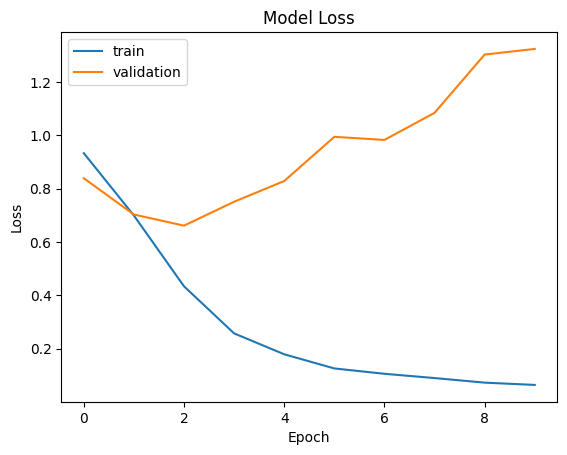

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming the maximum number of words in the tokenizer and sequence length
MAX_NB_WORDS = 10000   # limit for the number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 50  # maximum length of text sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['text_lemmatized'])
sequences = tokenizer.texts_to_sequences(data['text_lemmatized'])

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data_pad = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

from tensorflow.keras.utils import to_categorical

labels = to_categorical(np.asarray(data['encoded_category']))
print(f'Shape of data tensor: {data_pad.shape}')
print(f'Shape of label tensor: {labels.shape}')

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data_pad, labels, test_size=0.2, random_state=42)

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # Change the number of units to match the number of categories

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=2)

scores = model.evaluate(x_val, y_val, verbose=0)
print(f'Accuracy: {scores[1]*100:.2f}%')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# BI_Lstm

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Model Parameters
MAX_NB_WORDS = 10000   # Number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 50  # Maximum length of text sequences
EMBEDDING_DIM = 100    # Dimension of the embedding layer

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))
model.add(Dense(3, activation='softmax'))  # Number of classes: 3 (e.g., Positive, Negative, Neutral)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Assume x_train, y_train, x_val, y_val are already defined and preprocessed
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

# Evaluate the model
scores = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation Accuracy: {scores[1]*100:.2f}%')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 100)               60400     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1060703 (4.05 MB)
Trainable params: 1060703 (4.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
61/61

# RNN

In [43]:
from gensim.models import Word2Vec
import pandas as pd
from sklearn.model_selection import train_test_split

# Tokenize the text into lists of words
sentences = [row.split() for row in data['text_lemmatized']]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.train(sentences, total_examples=len(sentences), epochs=10)

# Save the model for later use
model.save("word2vec.model")

# Load the model
model = Word2Vec.load("word2vec.model")


# Convert all sentences to vectors
# This function averages all word vectors in a sentence to create a sentence vector
def sentence_to_avg_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

# Create sentence vectors for each sentence in the dataset
sentence_vectors = np.array([sentence_to_avg_vector(sentence, model) for sentence in sentences])

X = np.array(sentence_vectors)
Y = data["encoded_category"]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Check the shape of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (3876, 100)
X_test shape: (970, 100)
Y_train shape: (3876,)
Y_test shape: (970,)


In [44]:
from sklearn.model_selection import train_test_split

X = np.array(sentence_vectors)
Y = data["encoded_category"]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Check the shape of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (3876, 100)
X_test shape: (970, 100)
Y_train shape: (3876,)
Y_test shape: (970,)


In [45]:
import numpy as np

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.square(np.tanh(x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [46]:
seed = 100

class RNN:
    def __init__(self, input_size, output_size, hidden_size, activation='tanh', dropout_prob=0.3):

        np.random.seed(seed)

        # Initialize weights and biases
        self.Wxh = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)
        self.Whh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.Why = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)

        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        # Activation functions
        activation_functions = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'relu': (relu, relu_derivative),
            'leaky_relu': (leaky_relu, leaky_relu_derivative),
            'tanh': (tanh, tanh_derivative)
        }
        if activation in activation_functions:
            self.activation, self.activation_derivative = activation_functions[activation]
        else:
            raise ValueError(f"Unknown activation function: {activation}")

        self.dropout_prob = dropout_prob

    def forward(self, inputs, test=False):
        hs = np.zeros((self.Wxh.shape[0], 1))  # Initialize hidden state to zeros
        cache = {'hs': [np.copy(hs)], 'xs': []}  # Store states for backprop

        if not test:
            for input_vector in inputs:  # Assuming 'inputs' is iterable
                x = input_vector.reshape(-1, 1)  # Correct reshaping of each input vector
                cache['xs'].append(x)
                hs = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, hs) + self.bh)
                # Apply dropout
                dropout_mask = (np.random.rand(*hs.shape) < self.dropout_prob) / self.dropout_prob
                hs *= dropout_mask
                cache['hs'].append(np.copy(hs))
        else:
            x = inputs.reshape(-1, 1)  # Correct reshaping of each input vector
            cache['xs'].append(x)
            hs = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, hs) + self.bh)
            cache['hs'].append(np.copy(hs))

        y = np.dot(self.Why, hs) + self.by
        p = softmax(y)  # Ensure using sigmoid is correct; softmax might be needed if output_size > 1
        return p, cache

    def backward(self, ps, targets, cache):
        hs, xs = cache['hs'], cache['xs']
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])

        # Correct initialization of dy
        dy = ps - targets.reshape(-1, 1)  # ensure targets is reshaped correctly if it's not already

        for t in reversed(range(len(xs))):
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext
            dhraw = self.activation_derivative(hs[t]) * dh

            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T) if t > 0 else 0
            dbh += dhraw

            dhnext = np.dot(self.Whh.T, dhraw)

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby




    def update_params(self, learning_rate, grads):
        """
        Update the weights and biases using gradient descent.
        """
        dWxh, dWhh, dWhy, dbh, dby = grads
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

    def loss(self, ps, targets):
        # Convert targets to one-hot encoded vectors
        y_true = np.zeros((len(targets), ps.shape[0]))
        for i, label in enumerate(list(targets)):
            label = int(label)
            y_true[i, label] = 1
        # Clip the predictions to avoid log(0) error
        ps = np.clip(ps, 1e-12, 1 - 1e-12)

        # Compute the cross-entropy loss
        loss = -np.sum(y_true * np.log(ps)) / len(targets)
        return loss

    def train(self, X, Y, learning_rate, epochs):
        Y_one_hot = np.zeros((self.Why.shape[0], Y.shape[0]), dtype=int)
        for i, label in enumerate(Y):
            Y_one_hot[label, i] = 1

        for epoch in range(epochs):
            total_loss = 0
            for i in range(X.shape[0]):
                x = X[i].reshape(-1, 1)  # Each row in X is a full input for a timestep
                target = Y_one_hot[:, i]

                outputs, cache = self.forward([x])  # Pass x as a list if forward expects a sequence
                loss = self.loss(outputs, target)
                total_loss += loss
                grads = self.backward(outputs, target, cache)

                self.update_params(learning_rate, grads)

            print(f'Epoch {epoch+1}/{epochs}, Total Loss: {total_loss / X.shape[0]}')



    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            x = X[i].reshape(-1, 1)  # Ensure input vector is a column vector

            if x.shape[0] != self.Wxh.shape[1] or x.shape[1] != 1:
                raise ValueError(f"Input shape mismatch. Expected {(self.Wxh.shape[1], 1)}, got {x.shape}")

            probabilities, _ = self.forward(x, True)
            predictions.append(np.argmax(probabilities, axis=0))
        return np.array(predictions).flatten()  # Flatten to convert to 1D array if needed


    def accuracy(self, predictions, targets):
        """
        Compute the accuracy of predictions.

        :param predictions: np.array, predicted labels for the data
        :param targets: np.array, actual labels for the data
        :return: float, percentage of correct predictions
        """
        # Ensure both inputs are numpy arrays
        predictions = np.array(predictions)
        targets = np.array(targets)

        # Calculate the number of correct predictions
        correct = np.sum(predictions == targets)

        # Calculate accuracy as the proportion of correct predictions
        total = targets.shape[0]
        accuracy = correct / total * 100  # Multiply by 100 to get percentage

        return accuracy


In [47]:
rnn = RNN(input_size=100, output_size=3, hidden_size=2000, activation='sigmoid', dropout_prob=0.4)
rnn.train(X_train, Y_train, learning_rate=0.001, epochs=10)

# Predictions on test

predicted_labels = rnn.predict(X_test)
model_accuracy = rnn.accuracy(predicted_labels, Y_test)
print(f"Model accuracy: {model_accuracy:.2f}%")

Epoch 1/10, Total Loss: 1.491871355975533
Epoch 2/10, Total Loss: 1.5344413992797783
Epoch 3/10, Total Loss: 1.539667071629801
Epoch 4/10, Total Loss: 1.5664783669129185
Epoch 5/10, Total Loss: 1.5796656309783386
Epoch 6/10, Total Loss: 1.5942205753165255
Epoch 7/10, Total Loss: 1.5977593072372285
Epoch 8/10, Total Loss: 1.6102619951101336
Epoch 9/10, Total Loss: 1.6161370493636815
Epoch 10/10, Total Loss: 1.627565999047833
Model accuracy: 62.89%


# BERT

In [48]:
!pip install transformers==4.24.0
!pip install simpletransformers==0.63.11
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [49]:
data.head()

,n_words,text_lemmatized,encoded_category
0,22,accord gran plan move product russia although grow,1
1,29,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...,1
2,33,intern electron industri elcoteq lay ten employe tallinn facil contrari earlier layoff contract ...,0
3,32,with new product plant would increas capac meet expect increas demand would improv use raw mater...,2
4,34,accord updat strategi year baswar target longterm net growth rang profit margin net,2


In [50]:
data.rename(columns={'text_lemmatized': 'text'}, inplace=True)
data.rename(columns={'encoded_category': 'Sentiment'}, inplace=True)

In [51]:
data.drop_duplicates(subset=['text'],keep='first',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 0 to 4845
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   n_words    4738 non-null   int64 
 1   text       4738 non-null   object
 2   Sentiment  4738 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 148.1+ KB


In [52]:
train_data,eval_data = train_test_split(data,test_size = 0.2)

In [54]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel(
    'bert',
    'bert-base-cased',
    num_labels=3,
    args={
        'reprocess_input_data': True,
        'overwrite_output_dir': True
    },
    use_cuda=False  # Set this to False if CUDA is not available
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [55]:
import torch
print(torch.cuda.is_available())

False


In [56]:
# And also check the information to confirm the split
train_data.info()
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 2409 to 3556
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   n_words    3790 non-null   int64 
 1   text       3790 non-null   object
 2   Sentiment  3790 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 118.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, 3464 to 2103
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   n_words    948 non-null    int64 
 1   text       948 non-null    object
 2   Sentiment  948 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 29.6+ KB


In [57]:
data.head()

,n_words,text,Sentiment
0,22,accord gran plan move product russia although grow,1
1,29,technopoli plan develop stage area less squar meter order host work comput technolog telecommun ...,1
2,33,intern electron industri elcoteq lay ten employe tallinn facil contrari earlier layoff contract ...,0
3,32,with new product plant would increas capac meet expect increas demand would improv use raw mater...,2
4,34,accord updat strategi year baswar target longterm net growth rang profit margin net,2


In [58]:
def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1

train_data['label'] = train_data['Sentiment'].apply(making_label)
eval_data['label'] = eval_data['Sentiment'].apply(making_label)
print(train_data.head())

      n_words  \
2409       21   
3403       22   
2906       23   
313        21   
1010       19   

                                                                                                  text  \
2409                                 a altern exchang panostaja offer full cash consider valu euro per   
3403  ventur recent agre buy motorola wireless network busi billion deploy lightsquar nation g network   
2906              real estat sponda oyj april would build vuosaari harbour servic center port helsinki   
313                                               with extens new contract eight engin plant produc mw   
1010                                                    thank nokia lulu i proud publish hi novel find   

      Sentiment  label  
2409          1      1  
3403          1      1  
2906          1      1  
313           2      1  
1010          1      1  


In [59]:
train_df2 = pd.DataFrame({
    'text': train_data['text'].replace(r'\n', ' ', regex=True),
    'label': train_data['Sentiment']
})

eval_df2 = pd.DataFrame({
    'text': eval_data['text'].replace(r'\n', ' ', regex=True),
    'label': eval_data['Sentiment']
})

In [60]:
model.train_model(train_df2)

  0%|          | 0/3790 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/474 [00:00<?, ?it/s]

(474, 0.7328350822193713)

In [61]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df2)

  0%|          | 0/948 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/119 [00:00<?, ?it/s]

In [ ]:
print(result)
print(model_outputs)

In [63]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df2['label'].tolist()
predicted = lst

import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
print(mat)
print(25 * "==")
print(sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative']))

[[ 83  19  11]
 [ 26 471  63]
 [ 12  91 172]]
              precision    recall  f1-score   support

    positive       0.69      0.73      0.71       113
     neutral       0.81      0.84      0.83       560
    negative       0.70      0.63      0.66       275

    accuracy                           0.77       948
   macro avg       0.73      0.73      0.73       948
weighted avg       0.76      0.77      0.76       948



In [64]:
def get_result(statement):
    """
    Function to predict the sentiment directly from
    a statement. This function returns a string which could be (positive|negative|neutral)
    """
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
    return sentiment_dict[pos]

In [69]:
headlines = [
    "Adani Group to acquire big cement manufacturer, will become market leader",
  "Investors take a cautious approach to tech stocks after recent volatility",
  "Analysts raise concerns about the future of the retail industry",
  "Oil prices surge, raising fears of inflation",
  "Banks report strong earnings, but investors remain cautious",
  "Automakers post disappointing sales figures",
  "Tech giants face increasing scrutiny from regulators",
  "Healthcare stocks outperform the market as investors seek safety",
  "Industrials stocks struggle as investors worry about a slowdown in the global economy",
  "Consumer discretionary stocks rebound after recent sell-off",
  "Energy stocks surge on rising oil prices",
  "Materials stocks outperform the market as investors bet on a recovery in the global economy",
  "Utilities stocks continue to outperform the market as investors seek safety",
  "Telecom stocks struggle as investors worry about rising competition",
  "Real estate investment trusts (REITs) outperform the market as investors seek income",
  "Gold prices rise as investors seek safety",
  "Bitcoin prices surge, but analysts warn of a bubble",
  "The future of the stock market is uncertain, but investors are starting to look for bargains",
  "The stock market is expected to remain volatile in the near future",
    "Netflix faces increasing competition from Disney+ and other streaming services.",
    "Walmart's grocery delivery service faces challenges from Amazon Fresh and Instacart.",
    "Nike's sales growth slows as consumers shift to athleisure brands.",
    "McDonald's faces increasing competition from fast-casual chains like Chipotle and Panera Bread.",
    "Tesla's production ramp-up faces challenges as the company struggles to meet demand.",
    "Apple's iPhone sales miss expectations as consumers hold off on upgrading their phones.",
    "Amazon's cloud computing business faces challenges from Microsoft and Google.",
    "Facebook's advertising business faces pressure from regulators as the company is accused of misuse of user data.",
    "Exxon Mobil faces criticism for its environmental record as the company continues to drill for oil and gas.",
    "Netflix stock price surges on news of new subscriber growth.",
    "Walmart stock price rises on news of strong earnings.",
    "Nike stock price jumps after company reports better-than-expected earnings.",
    "McDonald's stock price climbs after company announces plans to open new restaurants.",
    "Tesla stock price soars on news of new battery technology.",
    "Apple stock price rises after company reports strong iPhone sales.",
    "Amazon stock price jumps on news of cloud computing growth.",
    "Facebook stock price climbs after company reports better-than-expected earnings.",
    "Exxon Mobil stock price rises after company reports strong oil and gas production.",
    "Netflix stock price falls after subscriber growth slows.",
    "Walmart stock price dips after company reports weaker-than-expected earnings.",
    "Nike stock price falls after company reports disappointing earnings.",
    "McDonald's stock price slides after company announces plans to close restaurants.",
    "Tesla stock price falls after company misses production targets.",
    "Apple stock price drops after company reports weak iPhone sales.",
    "Amazon stock price falls after company reports slower-than-expected cloud computing growth.",
    "Facebook stock price slides after company reports weaker-than-expected earnings.",
    "Exxon Mobil stock price falls after company reports lower oil and gas production.",
    "Netflix stock price surges on news of new content deals.",
    "Walmart stock price rises on news of new store openings.",
    "Nike stock price jumps after company announces new product launches.",
    "McDonald's stock price climbs after company reports strong same-store sales.",
    "Tesla stock price soars on news of new government subsidies.",
    "Apple stock price rises after company announces new product releases.",
    "Amazon stock price jumps on news of strong e-commerce growth.",
    "Facebook stock price climbs after company announces new advertising features.",
    "Exxon Mobil stock price rises after company reports higher oil prices.",
    "Netflix stock price falls after company loses subscribers.",
    "Walmart stock price dips after company reports weak same-store sales.",
    "Nike stock price falls after company announces recalls of its products.",
    "McDonald's stock price slides after company is accused of labor violations.",
    "Tesla stock price falls after company is fined for safety violations.",
    "Apple stock price drops after company is sued for patent infringement.",
    "Amazon stock price falls after company is criticized for its working conditions.",
    "Facebook stock price slides after company is accused of privacy violations.",
    "Exxon Mobil stock price falls after company is accused of environmental damage.",
    "Netflix reports subscriber growth slows",
    "Walmart earnings come in below expectations",
    "Nike profits decline for the first time in years",
    "McDonald's sales disappoint in key markets",
    "Tesla production falls short of targets for the second quarter",
    "Apple iPhone sales slow in the US",
    "Amazon cloud computing growth slows in the second quarter",
    "Facebook advertising revenue under pressure from privacy concerns",
    "Exxon Mobil profits fall as oil prices decline",
    "Goldman Sachs reports weaker-than-expected earnings",
    "Morgan Stanley earnings miss expectations",
    "JPMorgan Chase reports lower profits",
    "Wells Fargo earnings fall short of expectations",
    "Citigroup reports weaker-than-expected earnings",
    "Bank of America earnings miss expectations",
    "Barclays reports lower profits",
    "HSBC earnings fall short of expectations",
    "Deutsche Bank reports weaker-than-expected earnings",
    "Credit Suisse earnings miss expectations",
    "Netflix reports slower subscriber growth, as competition from other streaming services intensifies.",
    "Walmart earnings miss expectations, as the company faces rising costs and competition from Amazon.",
    "Nike profits decline, as the company faces challenges in its key markets.",
    "McDonald's sales disappoint, as the company struggles to attract new customers.",
    "Tesla production falls short of targets, as the company continues to ramp up production of its Model 3 sedan.",
    "Apple iPhone sales slow, as consumers hold off on upgrading their phones.",
    "Amazon cloud computing growth slows, as the company faces competition from Microsoft and Google.",
    "Facebook advertising revenue under pressure, as the company faces scrutiny over its privacy practices.",
    "Exxon Mobil profits fall, as oil prices decline.",
    "Goldman Sachs reports weaker-than-expected earnings, as the company faces headwinds from the trade war.",
    "Morgan Stanley earnings miss expectations, as the company's trading business struggles.",
    "JPMorgan Chase reports lower profits, as the company faces rising costs and increased regulation.",
    "Wells Fargo earnings fall short of expectations, as the company continues to grapple with its scandal.",
    "Citigroup reports weaker-than-expected earnings, as the company faces challenges in its investment banking business.",
    "Bank of America earnings miss expectations, as the company's consumer banking business faces headwinds.",
    "Barclays reports lower profits, as the company's investment banking business struggles.",
    "HSBC earnings fall short of expectations, as the company's retail banking business faces challenges.",
    "India Restricts Import Of Laptops, Computers ",
]

array = ['positive', 'neutral', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative','negative']

accuracy = -3.9

for i in range(len(headlines)):
    print(f"Headline : {headlines[i]}")
    sentiment = get_result(headlines[i])
    if (sentiment == array[i]):
        accuracy+=1
    print(f"Sentiment : {sentiment}")

print(f"The total Accuracy is -> {accuracy}")


Headline : Adani Group to acquire big cement manufacturer, will become market leader


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : negative
Headline : Investors take a cautious approach to tech stocks after recent volatility


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Analysts raise concerns about the future of the retail industry


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Oil prices surge, raising fears of inflation


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Banks report strong earnings, but investors remain cautious


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Automakers post disappointing sales figures


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Tech giants face increasing scrutiny from regulators


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Healthcare stocks outperform the market as investors seek safety


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Industrials stocks struggle as investors worry about a slowdown in the global economy


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Consumer discretionary stocks rebound after recent sell-off


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Energy stocks surge on rising oil prices


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Materials stocks outperform the market as investors bet on a recovery in the global economy


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Utilities stocks continue to outperform the market as investors seek safety


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Telecom stocks struggle as investors worry about rising competition


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Real estate investment trusts (REITs) outperform the market as investors seek income


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Gold prices rise as investors seek safety


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Bitcoin prices surge, but analysts warn of a bubble


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : The future of the stock market is uncertain, but investors are starting to look for bargains


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : negative
Headline : The stock market is expected to remain volatile in the near future


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Netflix faces increasing competition from Disney+ and other streaming services.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Walmart's grocery delivery service faces challenges from Amazon Fresh and Instacart.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Nike's sales growth slows as consumers shift to athleisure brands.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : McDonald's faces increasing competition from fast-casual chains like Chipotle and Panera Bread.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Tesla's production ramp-up faces challenges as the company struggles to meet demand.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Apple's iPhone sales miss expectations as consumers hold off on upgrading their phones.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Amazon's cloud computing business faces challenges from Microsoft and Google.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Facebook's advertising business faces pressure from regulators as the company is accused of misuse of user data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Exxon Mobil faces criticism for its environmental record as the company continues to drill for oil and gas.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Netflix stock price surges on news of new subscriber growth.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Walmart stock price rises on news of strong earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Nike stock price jumps after company reports better-than-expected earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : McDonald's stock price climbs after company announces plans to open new restaurants.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Tesla stock price soars on news of new battery technology.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Apple stock price rises after company reports strong iPhone sales.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Amazon stock price jumps on news of cloud computing growth.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Facebook stock price climbs after company reports better-than-expected earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Exxon Mobil stock price rises after company reports strong oil and gas production.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Netflix stock price falls after subscriber growth slows.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Walmart stock price dips after company reports weaker-than-expected earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Nike stock price falls after company reports disappointing earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : McDonald's stock price slides after company announces plans to close restaurants.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Tesla stock price falls after company misses production targets.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Apple stock price drops after company reports weak iPhone sales.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Amazon stock price falls after company reports slower-than-expected cloud computing growth.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Facebook stock price slides after company reports weaker-than-expected earnings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Exxon Mobil stock price falls after company reports lower oil and gas production.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Netflix stock price surges on news of new content deals.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Walmart stock price rises on news of new store openings.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Nike stock price jumps after company announces new product launches.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : McDonald's stock price climbs after company reports strong same-store sales.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Tesla stock price soars on news of new government subsidies.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Apple stock price rises after company announces new product releases.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Amazon stock price jumps on news of strong e-commerce growth.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Facebook stock price climbs after company announces new advertising features.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Exxon Mobil stock price rises after company reports higher oil prices.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : neutral
Headline : Netflix stock price falls after company loses subscribers.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Walmart stock price dips after company reports weak same-store sales.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Nike stock price falls after company announces recalls of its products.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : McDonald's stock price slides after company is accused of labor violations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Tesla stock price falls after company is fined for safety violations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Apple stock price drops after company is sued for patent infringement.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Amazon stock price falls after company is criticized for its working conditions.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Facebook stock price slides after company is accused of privacy violations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Exxon Mobil stock price falls after company is accused of environmental damage.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Netflix reports subscriber growth slows


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Walmart earnings come in below expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Nike profits decline for the first time in years


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : McDonald's sales disappoint in key markets


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Tesla production falls short of targets for the second quarter


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Apple iPhone sales slow in the US


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Amazon cloud computing growth slows in the second quarter


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Facebook advertising revenue under pressure from privacy concerns


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Exxon Mobil profits fall as oil prices decline


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Goldman Sachs reports weaker-than-expected earnings


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Morgan Stanley earnings miss expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : JPMorgan Chase reports lower profits


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Wells Fargo earnings fall short of expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Citigroup reports weaker-than-expected earnings


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Bank of America earnings miss expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Barclays reports lower profits


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : HSBC earnings fall short of expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Deutsche Bank reports weaker-than-expected earnings


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Credit Suisse earnings miss expectations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Netflix reports slower subscriber growth, as competition from other streaming services intensifies.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Walmart earnings miss expectations, as the company faces rising costs and competition from Amazon.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Nike profits decline, as the company faces challenges in its key markets.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : McDonald's sales disappoint, as the company struggles to attract new customers.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Tesla production falls short of targets, as the company continues to ramp up production of its Model 3 sedan.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Apple iPhone sales slow, as consumers hold off on upgrading their phones.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Amazon cloud computing growth slows, as the company faces competition from Microsoft and Google.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Facebook advertising revenue under pressure, as the company faces scrutiny over its privacy practices.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Exxon Mobil profits fall, as oil prices decline.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Goldman Sachs reports weaker-than-expected earnings, as the company faces headwinds from the trade war.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Morgan Stanley earnings miss expectations, as the company's trading business struggles.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : JPMorgan Chase reports lower profits, as the company faces rising costs and increased regulation.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Wells Fargo earnings fall short of expectations, as the company continues to grapple with its scandal.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Citigroup reports weaker-than-expected earnings, as the company faces challenges in its investment banking business.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Bank of America earnings miss expectations, as the company's consumer banking business faces headwinds.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : Barclays reports lower profits, as the company's investment banking business struggles.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : HSBC earnings fall short of expectations, as the company's retail banking business faces challenges.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : positive
Headline : India Restricts Import Of Laptops, Computers 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sentiment : negative
The total Accuracy is -> 0.10000000000000009


In [73]:
sentiment = get_result("Healthcare stocks outperform the market as investors seek safety")
print(sentiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

neutral


In [77]:
sentiment = get_result("Exxon Mobil stock price rises after company reports hiher oil and gas production.Energy stocks lower on oil prices")
print(sentiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

positive


In [76]:
sentiment = get_result("Exxon Mobil stock price rises after company reports hiher oil and gas production.Energy stocks lower on oil prices")
print(sentiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

neutral


In [71]:
sentiment = get_result("Samsung to face lawsuit for breaching terms of agreement")
print(sentiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

negative


# Result
After training the model it was able to classify if the statement was positive or negative